In [1]:
#Loading Packages
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
library(rvest)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#Reading Data
url <- "http://roycekimmons.com/system/generate_data.php?dataset=exams&n=1000"
exam_data <- read_csv(url)
colnames(exam_data) <- c("gender", "race_ethnicity", "parental_level_of_education", "lunch", "test_preparation_course", "math_score", "reading_score", "writing_score")
set.seed(2000)

Rows: 1000 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): gender, race/ethnicity, parental level of education, lunch, test pr...
dbl (3): math score, reading score, writing score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
#Split
exam_split <- exam_data %>%
  initial_split(prop = 0.75, strata = writing_score)

In [4]:
#Assigning Training Data
exam_training <- exam_split %>%
  training()

In [5]:
#Assigning Testing Data
exam_testing <- exam_split %>%
  testing()

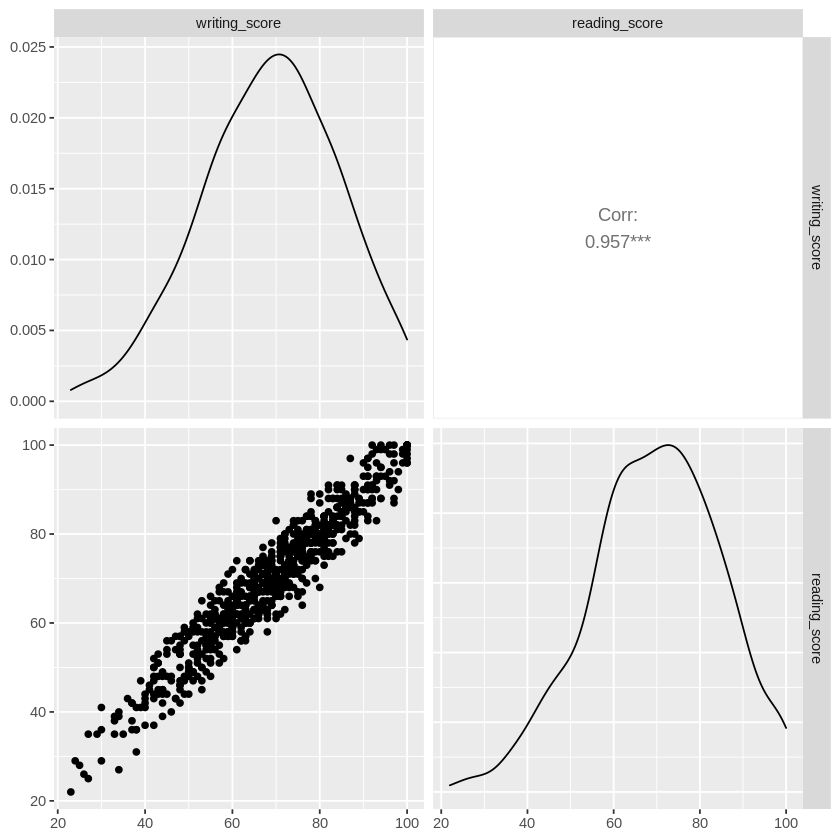

In [6]:
#Analyzing association between writing_score & reading_score *training data*
exam_eda <- exam_training %>%
    select(writing_score, reading_score) %>%
    ggpairs()
exam_eda

In [7]:
#K-nn Regression Model Specificiation
exam_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

In [8]:
#Recipe with Standardization
exam_recipe <- recipe(writing_score ~ reading_score, data = exam_training) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

In [9]:
#Cross Validation with 5 folds on training data
exam_vfold <- exam_training %>%
  vfold_cv(v = 5, strata = writing_score)

In [10]:
#Creating workflow
exam_workflow <- workflow() %>%
  add_recipe(exam_recipe) %>%
  add_model(exam_spec)

In [11]:
#Setting grid parameters
gridvals <- tibble(neighbors = seq(from = 1, to = 200, by = 10))

In [12]:
#Collecting statistics from model
exam_results <- exam_workflow %>%
  tune_grid(resamples = exam_vfold, grid = gridvals) %>%
  collect_metrics()

In [13]:
#Finding the minimum RMSE (mean value)
exam_min <- exam_results %>%
  filter(.metric == "rmse") %>%
  arrange(mean) %>%
  slice(1)
exam_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
21,rmse,standard,4.692669,5,0.09959209,Preprocessor1_Model03


In [14]:
#Assigning optimal K value to an object
k_min <- exam_min %>%
  pull(neighbors)

In [15]:
#Creating an object that only includes "rmse" in .metric (but with all data)
exam_results_cleanup <- exam_results %>%
  filter(.metric == "rmse")

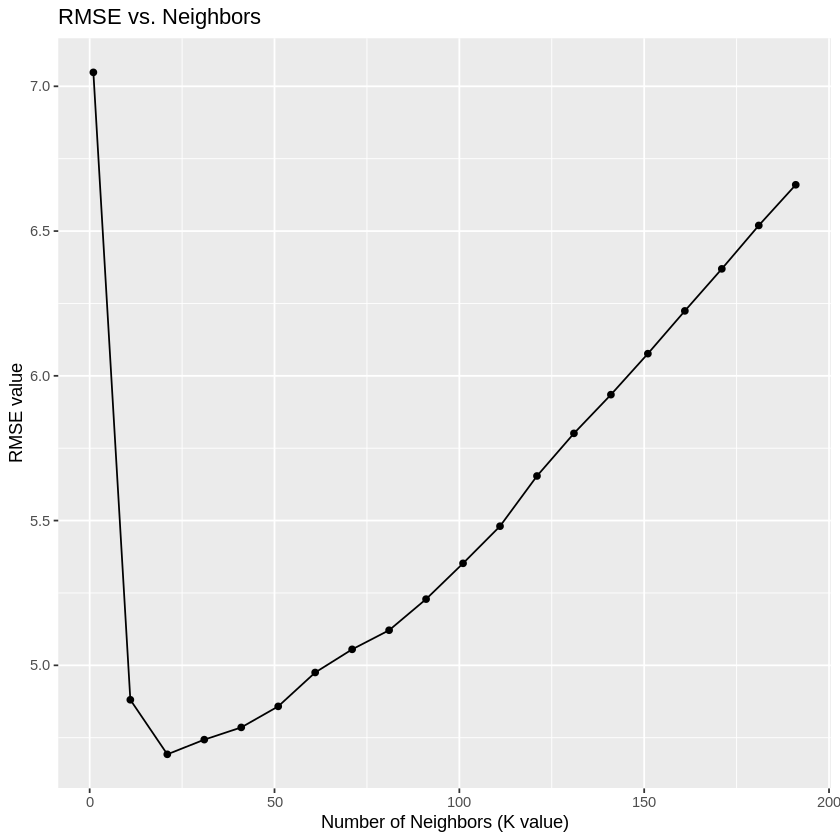

In [16]:
#Creating a plot with # of neighbors on x, rmse value on y.
rmse_plot <- exam_results_cleanup %>%
  ggplot(aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Number of Neighbors (K value)", y = "RMSE value") +
  ggtitle("RMSE vs. Neighbors")
rmse_plot

In [17]:
#Making new model specification, but now with the optimal K value
exam_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
  set_engine("kknn") %>%
  set_mode("regression")

In [18]:
#New workflow
exam_best_workflow <- workflow() %>%
  add_recipe(exam_recipe) %>%
  add_model(exam_best_spec) %>%
  fit(data = exam_training)

In [19]:
#Making prediction
exam_predict <- exam_best_workflow %>%
  predict(exam_testing) %>%
  bind_cols(exam_testing)

In [20]:
#Getting metrics
exam_metrics <- exam_predict %>%
  metrics(truth = writing_score, estimate = .pred)
exam_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.4691685
rsq,standard,0.9129987
mae,standard,3.6325175


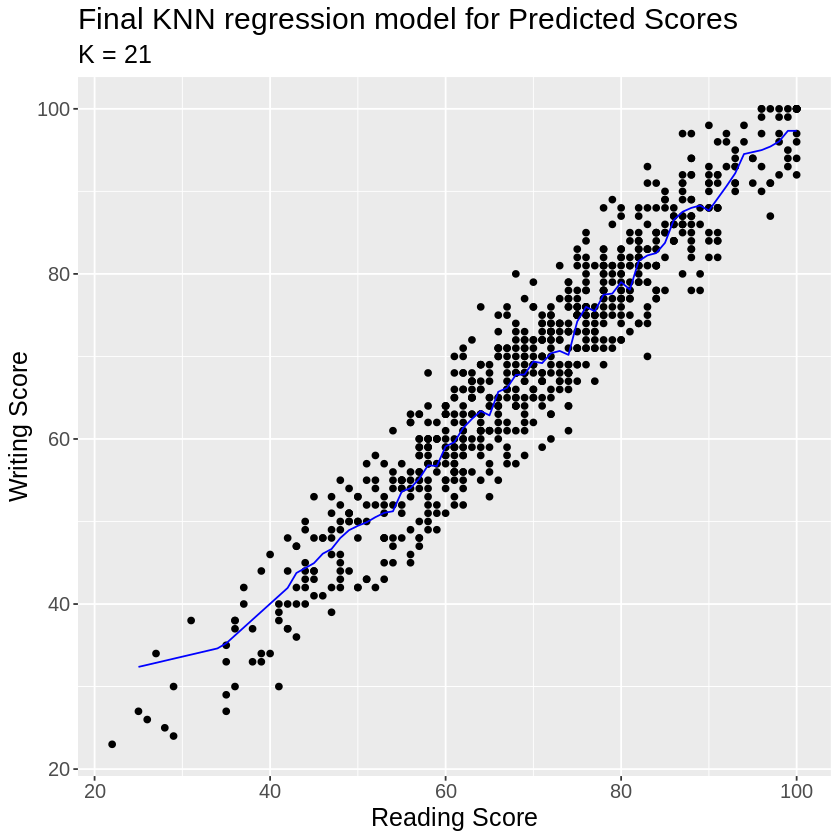

In [21]:
#Scatter plot with Y-predictions line.
predict_plot <- exam_training |>
    ggplot(aes(x = reading_score, y = writing_score)) +
    geom_point() +
    geom_line(data = exam_predict, mapping = aes(x = reading_score, y = .pred), color = "blue") +
    labs(x = "Reading Score", y = "Writing Score") +
    ggtitle("Final KNN regression model for Predicted Scores", paste0("K = ", k_min)) +
    theme(text = element_text(size = 15))
predict_plot

In [22]:
#Linear Regression Model Specification
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

In [23]:
#Recipe 
lm_recipe <- recipe(writing_score ~ reading_score, data = exam_training)

In [24]:
#Creating Workflow and Determining Line of Best Fit
lm_fit <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = exam_training)
lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
  (Intercept)  reading_score  
      -0.4963         0.9939  


In [25]:
#Assessing the Model
lm_test_results <- lm_fit |>
  predict(exam_testing) |>
  bind_cols(exam_testing) |>
  metrics(truth = writing_score, estimate = .pred)
lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.4474357
rsq,standard,0.9141387
mae,standard,3.5715030


In [26]:
#Calculate RMSPE
lm_rmspe <- lm_test_results |>
          filter(.metric == "rmse") |>
          select(.estimate) |>
          pull()
lm_rmspe

[1] 4.447436

`geom_smooth()` using formula 'y ~ x'



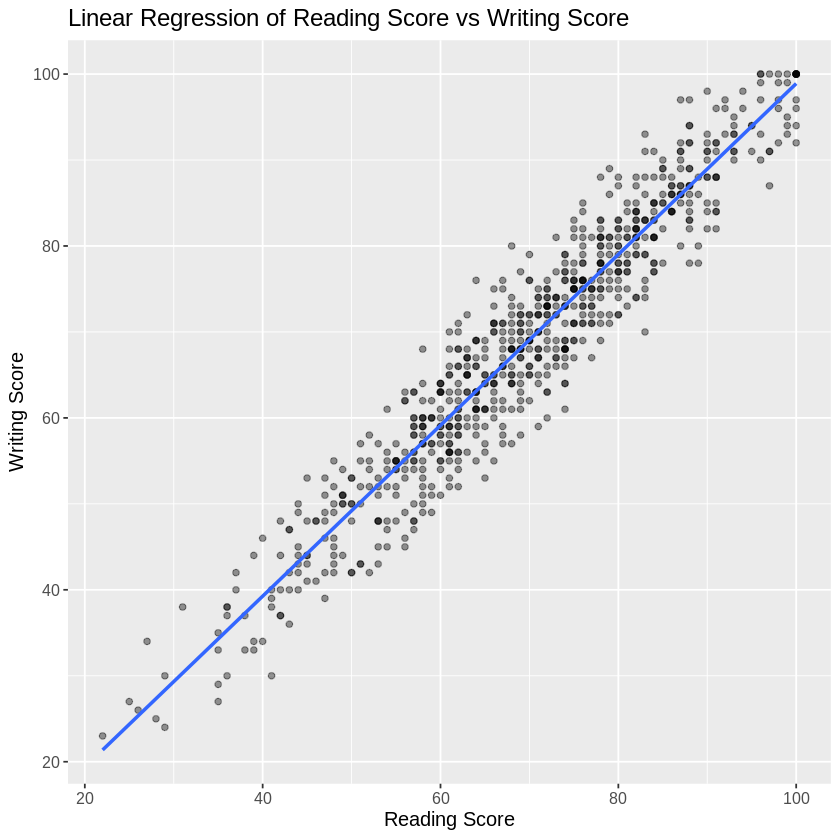

In [27]:
#Scatter plot with Line of Best Fit
lm_plot_final <- ggplot(exam_training, aes(x = reading_score, y = writing_score)) +
  geom_point(alpha = 0.4) +
  xlab("Reading Score") +
  ylab("Writing Score") +
  ggtitle("Linear Regression of Reading Score vs Writing Score")+
  geom_smooth(method = "lm", se = FALSE) + 
  theme(text = element_text(size = 12))
lm_plot_final

`geom_smooth()` using formula 'y ~ x'



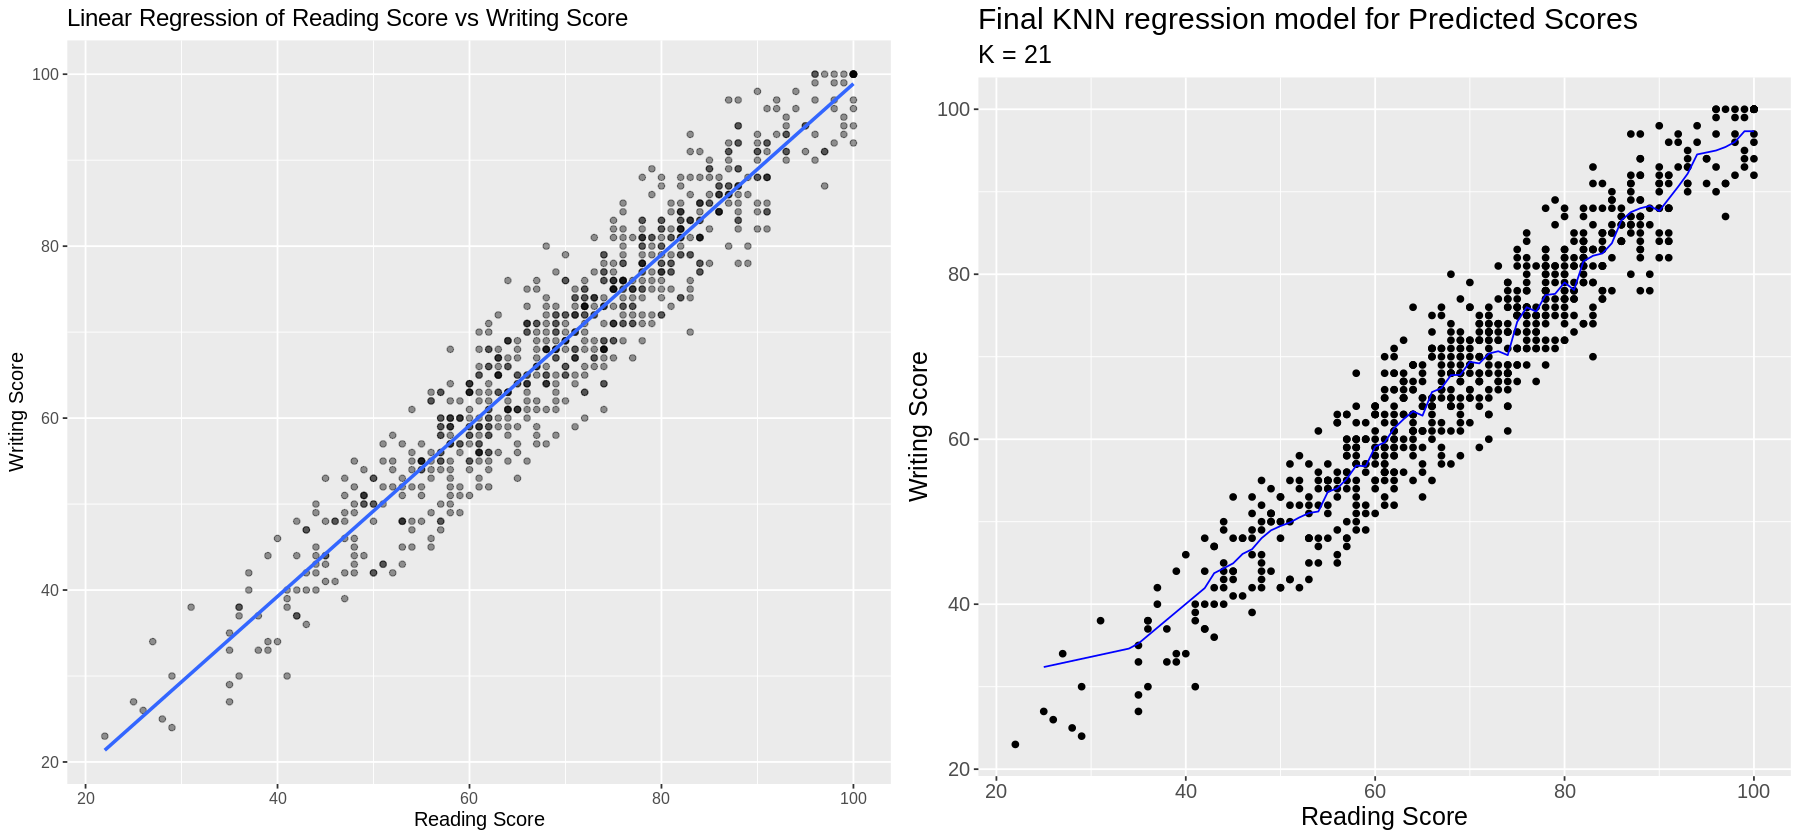

In [28]:
#Comparing Plots of Linear Regression and KNN-Regression Models
library(cowplot)
options(repr.plot.width = 15, repr.plot.height = 7)
plot_grid(lm_plot_final, predict_plot, ncol = 2)